# Cтоимость автомобиля на вторичном рынке

**Задача** - разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.

**Источник данных** - kaggle

**Описание полей данных**

'year' - год производства

'make' - производитель

'model' - модель

'trim' - модификация

'body' - тип кузова

'transmission' - тип КПП

'vin' - идентификатор (вин)

'state' - штат регистрации

'condition' - состояние по шкале (1-5)

'odometer' - пробег в милях

'color' - цвет кузова

'interior' - цвет интерьера

'seller' - продавец

'sellingprice' - стоимость продажи

'saledate' - дата продажи



**Содержание**

1) Загрузка и подготовка данных

2) Исследовательский анализ данных 


**Оценка качества**

Основная метрика для оценки качества Mean absolute percentage error

## Загрузка и подготовка данных

In [1]:
#импортируем нужные библиотеки для работы

import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV)

from sklearn.preprocessing import (StandardScaler, 
                                   OrdinalEncoder, 
                                   OneHotEncoder)

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


import sklearn.metrics
from sklearn.metrics import mean_absolute_percentage_error


import phik
from phik import report
from phik.report import plot_correlation_matrix

import ydata_profiling
from tqdm import tqdm
from vininfo import Vin



In [2]:
#прочитаем данные 
pth1 = 'C:/Users/Lerusik/Desktop\Мастерская/train.csv' #'C:/Users/Lerusik/Desktop\Мастерская/train.csv'
pth2 = 'C:/Users/Lerusik/Desktop\Мастерская/test.csv'

data_train = pd.read_csv(pth1)
data_test = pd.read_csv(pth2)

## Обработка признаков (Тренировочная дата)



### Знакомство с данными

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [4]:
#посмотрим явные дубликаты
data_train.duplicated().sum()

0

#### Выводы и план подготовки данных:


Стоит поработать со стилем, пробелами и дальше обрабатывать  признаки


Признаки:

1) year - вопросов нет, пропусков нет, есть скос распределения вправо, поскольку есть тенденция к увеличению выпуска машин ближе к нашим дням, как и их продажа с помощью агрегатора

2) make(марка) - имеется почти 2% пропусков. Также имеется 92 уникальные марки. Возможным решением проблемы будет замена неизвестных марок на 'unknow', но скорее всего удаление этих данных из таблицы. Также интересно посмотреть, в каких годах встречаются неизвестные машины и имеются ли у них модели

3) model. Здесь много пропусков(2%). Надо посмотреть их связь с марками и годами и если не получится заполнить, то удалить. Ситуация аналогична пункту 2)

4) trim (модификация) также имеет множество уникальных значений. Также почти 2% пропусков. Скорее всего модификация в этих машинах просто отсутсвует, поэтому можно заменить её на 'unknow'

5) body(тип кузова) также имеет пропуски. В данном случае можно посмотреть марки и заполнить частовстречающимися значениями

6) transmission(коробка передач) имеет пропуски. Надо смотреть по дате, с какого-то года машины в основном на автомате, а еслиэто механика, то это скорее укажут

7) state (штат регистрации) пропусков нет

8) condition(состояние по шкале (1-5)) имеет корреляцию с целевым признаком. Есть пропуски. Также есть смысл округлить данные

9) odometer(пробег в милях) также сильно коррелирует с цп. Есть пропуски, вероятно связаны с продажей новой машины или техническим пропуском

10) color и interior имеют пропуски. Возможно это необычная окраска. Имеет смысл объединить их одним названием

11) seller пропусков нет, но стоит поработать со стилем написания

12) saledate необходимо разбить на отдельные столбцы с годом и остальными датами

### Обработка пропусков и создание новых признаков

In [5]:
#saledate
data_train['saledate'] = pd.to_datetime(data_train['saledate'], utc=True)
data_train['saledate'] = data_train['saledate'].dt.tz_localize(None)

#созадим новые столбцы
data_train['year_buy'] = data_train['saledate'].dt.year


#years_old
#созадим новый столбец - сколько машине лет
data_train['years_old'] = data_train['year_buy'] - data_train['year']


In [6]:
#отредактируем написание
columns = data_train.columns
for col in columns:
    if data_train[col].dtypes == 'O': #если строки
        data_train[col] = data_train[col].str.lower() #приведем символы к нижнему регистру
        data_train[col] = data_train[col].str.strip() #удаление пробелов в начале и конце строки

In [7]:
#make

#заполним пропуски в производителе с помощью определителя по vin
def make(vin):
    return Vin(vin).manufacturer

data_train.loc[data_train['make'].isna(), 'make'] = data_train.loc[data_train['make'].isna(), 'vin'].apply(make)

#напишем функцию для замены неявных дубликатов
def make_ok(row):
    if pd.isna(row) == False:
        if 'mercedes' in row:
            row = 'mercedes'
        elif 'ford'  in row:
            row = 'ford'
        elif 'dodge'  in row:
            row = 'dodge'
        elif 'gmc'  in row:
            row = 'gmc'
        elif 'bmw'  in row:
            row = 'bmw'
        elif 'chevrolet'  in row:
            row = 'chevrolet'
        elif 'chrysler'  in row:
            row = 'chrysler'
        elif 'daimler'  in row:
            row = 'daimler'
        elif 'mazda'  in row:
            row = 'mazda'
        elif 'porsche'  in row:
            row = 'porsche'
        elif 'volkswagen' in row or 'vw'  in row:
            row = 'volkswagen'
        elif 'land'  in row:
            row = 'land rover'
        else:
            row = row
    else:
        row = row

    return row   
            
            
data_train['make'] = data_train['make'].apply(make_ok)            
            
#заменим редкие на unknown
data_train['make'] = data_train['make'].replace('am','aston martin')
data_train['make'] = data_train['make'].replace('airstream','unknown')
data_train['make'] = data_train['make'].replace('dot','unknown')
data_train['make'] = data_train['make'].replace('lamborghini','unknown')
data_train['make'] = data_train['make'].replace('unsupportedbrand','unknown')


#заменим пропуски
data_train.loc[data_train['make'].isna(), 'make'] = 'unknown'

In [8]:
#model


#приведем к однотипным названиям
data_train['model'] = data_train['model'].replace('subrbn','suburban')
data_train['model'] = data_train['model'].replace('series','') 
data_train['model'] = data_train['model'].replace('-series','')
data_train['model'] = data_train['model'].replace('class','') 
data_train['model'] = data_train['model'].replace('-class','')
 

#заменим пропуски
data_train.loc[data_train['model'].isna(), 'model'] = 'unknown'

In [9]:
#body
#заменим пропуски
data_train.loc[data_train['body'].isna(), 'body'] = 'unknown'

#напишем функцию для замены неявных дубликатов
def body_ok(row):
    if pd.isna(row) == False:
        if 'cts' in row:
            row = 'cts'
        elif 'van'  in row:
            row = 'van'
        elif 'cab'  in row:
            row = 'cab'
        elif 'convertible'  in row:
            row = 'convertible'
        elif 'coupe'  in row:
            row = 'coupe'
        elif 'wagon'  in row:
            row = 'wagon'
        elif 'sedan'  in row:
            row = 'sedan'
        elif 'wagon'  in row:
            row = 'wagon'
        elif 'hatchback'  in row:
            row = 'hatchback'
        elif 'suv'  in row:
            row = 'suv'
        else:
            row = row
    else:
        row = row
    return row

data_train['body'] = data_train['body'].apply(body_ok)  

In [10]:
#color и interior

#заменим пропуски 
data_train['color'] = data_train['color'].fillna('—')
data_train['interior'] = data_train['interior'].fillna('—')

In [11]:
#seller

#если продали меньше 1000 машин, то сделаем их "другие"
new = data_train['seller'].value_counts()
new = list(new[new<1000].index)

data_train['seller'] = data_train['seller'].replace(new, 'unknown')

#заменим пропуски на unknow
data_train['seller'] = data_train['seller'].fillna('unknown')

In [12]:
#condition

warnings.filterwarnings('ignore') #отключаем предубеждения

#заменим пропуски на среднее состояние по возрасту машин
for years_old in data_train['years_old'].unique():
    median_condition = data_train.loc[data_train['years_old'] == years_old, 'condition'].median()
    data_train.loc[(data_train['condition'].isna()) & (data_train['years_old'] == years_old), 'condition'] = median_condition
    
data_train['condition'] = data_train['condition'].replace([np.inf, -np.inf], np.nan)

#удалим пропуски
data_train = data_train.dropna(subset=['condition'])

In [13]:
#trim


new = data_train['trim'].value_counts()
new = new[new<10].index

data_train['trim'] = data_train['trim'].replace(new, 'unknown')

#заменим пропуски 
data_train['trim'] = data_train['trim'].fillna('no')

In [14]:
#transmission

warnings.filterwarnings("ignore")

#заменим пропуски 
data_train['transmission'] = data_train['transmission'].fillna('automatic')


In [15]:
#odometer
#пропуски можно заполнить медианой по году выпуска и году продажи

warnings.filterwarnings('ignore') #отключаем предубеждения

for year in data_train['year'].unique():
    for year_buy in data_train['year_buy'].unique():
        median_odometer = data_train.loc[(data_train['year'] == year) & (data_train['year_buy'] == year_buy), 'odometer'].median()
        data_train.loc[(data_train['odometer'].isna()) & (data_train['year'] == year) & (data_train['year_buy'] == year_buy), 'odometer'] = median_odometer
    
data_train['odometer'] = data_train['odometer'].replace([np.inf, -np.inf], np.nan)

#удалим пропуски
data_train = data_train.dropna(subset=['odometer']) 

### Выбросы и аномалии

In [16]:
anomal_odometer = max(data_train['odometer'])*0.5

data_train = data_train.query('odometer < @anomal_odometer')

In [17]:
anomal_sellingprice = max(data_train['sellingprice'])*0.6

data_train = data_train.query('sellingprice < @anomal_sellingprice')

In [18]:
#посмотрим распределния
data_train.describe()

,year,condition,odometer,sellingprice,year_buy,years_old
count,440136.000000,440136.000000,440136.000000,440136.000000,440136.000000,440136.000000
mean,2010.040499,3.413651,68231.913586,13581.609900,2014.902519,4.862020
std,3.977542,0.947252,52460.032169,9660.453416,0.296612,3.953976
min,1982.000000,1.000000,1.000000,1.000000,2014.000000,-1.000000
25%,2007.000000,2.700000,28262.000000,6900.000000,2015.000000,2.000000
50%,2012.000000,3.600000,52102.000000,12100.000000,2015.000000,3.000000
75%,2013.000000,4.200000,99272.250000,18200.000000,2015.000000,7.000000
max,2015.000000,5.000000,495757.000000,134500.000000,2015.000000,33.000000


## Обработка признаков (Тестовая дата)

### Знакомство с данными

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


### Обработка пропусков и создание новых признаков

In [20]:
#Объявим функцию func с одним параметром:
#Функция отыскивает новые категории в категориальных столбцах датафрейма data_test,которые отсутствуют в категориальных столбцах датафрейма data_train и объединяет их в категорию 'unknown'.
#Параметры: col_name (string) - наименование столбца датафрейма
        
def func(col_name):
    # Создадим пустой список, в который войдут наименования категорий, отсутствующих в выбранном столбце датафрейма data_train:
    differences_list = []
    # Если значение из списка уникальных значений выбранного столбца датафрейма data_test:
    for i in list(data_test[col_name].unique()):
        # отсутствует в списке уникальных значений аналогичного столбца датафрейма data_train:
        if i not in list(data_train[col_name].unique()):
            # добавим это значение в список differences_list:
            differences_list.append(i)
            # Объединим категории из списка differences_list для выбранного столбца датафрейма data_test в категорию 'unknown':        
    data_test[col_name] = data_test[col_name].replace(differences_list, 'unknown')
    # Вернём выбранный столбец датафрейма data_test:  
    return data_test[col_name]
    
        
        
    

In [21]:
#saledate
data_test['saledate'] = pd.to_datetime(data_test['saledate'], utc=True)
data_test['saledate'] = data_test['saledate'].dt.tz_localize(None)

#созадим новые столбцы
data_test['year_buy'] = data_test['saledate'].dt.year


#years_old
#созадим новые столбцы - сколько машине лет
data_test['years_old'] = data_test['year_buy'] - data_test['year']

In [22]:
#condition
warnings.filterwarnings('ignore') #отключаем предупреждения

for years_old in data_test['years_old'].unique():
    #median_condition = data_test.loc[data_test['years_old'] == years_old, 'condition'].median()
    data_test.loc[(data_test['condition'].isna()) & (data_test['years_old'] == years_old), 'condition'] = median_condition
    
#data_test['condition'] = data_test['condition'].replace([np.inf, -np.inf], np.nan)

In [23]:
#поправим написание
columns = data_test.columns
for col in columns:
    if data_test[col].dtypes == 'O': #если строки
        data_test[col] = data_test[col].str.lower() #приведем символы к нижнему регистру
        data_test[col] = data_test[col].str.strip() #удаление пробелов в начале и конце строки

In [24]:
#model

data_test['model'] = data_test['model'].replace('subrbn','suburban')
data_test['model'] = data_test['model'].replace('series','') 
data_test['model'] = data_test['model'].replace('-series','')
data_test['model'] = data_test['model'].replace('class','') 
data_test['model'] = data_test['model'].replace('-class','')

#заменим пропуски
data_test.loc[data_test['model'].isna(), 'model'] = 'unknown'

# Заполним неизвестные категории в столбце 'model' data_test:
data_test['model'] = func('model')

In [25]:
#make

data_test.loc[data_test['make'].isna(), 'make'] = data_test.loc[data_test['make'].isna(), 'vin'].apply(make)


#заменим пропуски
data_test.loc[data_test['make'].isna(), 'make'] = 'unknown'


#применим функцию и избавимся от разного написания
data_test['make'] = data_test['make'].apply(make_ok)

# Заполним неизвестные категории в столбце 'make' data_test:
data_test['make'] = func('make')

In [26]:
#body

#заменим пропуски
data_test.loc[data_test['body'].isna(), 'body'] = 'unknown'


#применим функцию и избавимся от разного написания
data_test['body'] = data_test['body'].apply(body_ok)  

# Заполним неизвестные категории в столбце 'body' data_test:
data_test['body'] = func('body')

In [27]:
#trim
#заменим пропуски 
data_test['trim'] = data_test['trim'].fillna('no')

# Заполним неизвестные категории в столбце 'trim' data_test:
data_test['trim'] = func('trim')

In [28]:
#state
# Заполним неизвестные категории в столбце 'state' data_test:
data_test['state'] = func('state')

In [29]:
#color и interior
#заменим пропуски 
data_test['color'] = data_test['color'].fillna('—')
data_test['interior'] = data_test['interior'].fillna('—')

# Заполним неизвестные категории в столбце 'color' data_test:
data_test['color'] = func('color')

# Заполним неизвестные категории в столбце 'interior' data_test:
data_test['interior'] = func('interior')

In [30]:
#transmission
#заменим пропуски 
warnings.filterwarnings("ignore")
data_test['transmission'] = data_test['transmission'].fillna('automatic')



In [31]:
#seller

# Заполним неизвестные категории в столбце 'seller' data_test:
data_test['seller'] = func('seller')

In [32]:
#odometer
#пропуски можно заполнить медианой по году выпуска и году продажи

warnings.filterwarnings('ignore') #отключаем предубеждения

for year in data_test['year'].unique():
    for year_buy in data_test['year_buy'].unique():
        #median_odometer = data_test.loc[(data_test['year'] == year) & (data_test['year_buy'] == year_buy), 'odometer'].median()
        data_test.loc[(data_test['odometer'].isna()) & (data_test['year'] == year) & (data_test['year_buy'] == year_buy), 'odometer'] = median_odometer
    
    
#оставшиеся заполню общей медианой по трейну
one_median_odometer = data_train['odometer'].median()
data_test.loc[data_test['odometer'].isna(), 'odometer'] = one_median_odometer

## Проверка обработки

In [33]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          110060 non-null  int64         
 1   make          110060 non-null  object        
 2   model         110060 non-null  object        
 3   trim          110060 non-null  object        
 4   body          110060 non-null  object        
 5   transmission  110060 non-null  object        
 6   vin           110060 non-null  object        
 7   state         110060 non-null  object        
 8   condition     110060 non-null  float64       
 9   odometer      110060 non-null  float64       
 10  color         110060 non-null  object        
 11  interior      110060 non-null  object        
 12  seller        110060 non-null  object        
 13  saledate      110060 non-null  datetime64[ns]
 14  year_buy      110060 non-null  int64         
 15  years_old     110

In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440136 entries, 0 to 440235
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          440136 non-null  int64         
 1   make          440136 non-null  object        
 2   model         440136 non-null  object        
 3   trim          440136 non-null  object        
 4   body          440136 non-null  object        
 5   transmission  440136 non-null  object        
 6   vin           440136 non-null  object        
 7   state         440136 non-null  object        
 8   condition     440136 non-null  float64       
 9   odometer      440136 non-null  float64       
 10  color         440136 non-null  object        
 11  interior      440136 non-null  object        
 12  seller        440136 non-null  object        
 13  sellingprice  440136 non-null  int64         
 14  saledate      440136 non-null  datetime64[ns]
 15  year_buy      440

In [35]:
#посмотрим явные дубликаты
data_train.duplicated().sum()

0

**Посмотрим количество категорий в категориальных признаках**

In [36]:
columns_test = data_train.drop(['condition', 'odometer'], axis=1).columns
for col in columns_test:

    print(f"""Уникальные значения в столбце {col}: {data_train[col].sort_values().unique()}""")
    print(f"""Bcero:{data_train[col].nunique()}""")
    print()

Уникальные значения в столбце year: [1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015]
Bcero:34

Уникальные значения в столбце make: ['AM' 'Acura' 'Audi' 'BMW' 'BMW M' 'Buick' 'CAMI' 'Cadillac' 'Chevrolet'
 'Chevrolet Canada' 'Chevrolet Mexico' 'Chevrolet USA' 'Chrysler'
 'Chrysler Canada' 'Daimler AG (Sprinter)' 'DaimlerChrysler AG/Daimler AG'
 'Dodge' 'Dodge Canada' 'Dodge Mexico' 'Ferrari' 'Fiat' 'Ford' 'GMC'
 'GMC Truck' 'Genesis' 'Honda' 'Hummer' 'Hyundai' 'Jaguar' 'Jeep' 'Kia'
 'Land Rover' 'Lexus' 'Lincoln' 'Maserati' 'Mazda' 'Mercedes-Benz'
 'Mercedes-Benz (Sprinter)' 'Mercury' 'Mitsubishi' 'Nissan' 'Oldsmobile'
 'Plymouth' 'Pontiac' 'Porsche SUV' 'Porsche car' 'Saab' 'Saturn' 'Scion'
 'Smart' 'Subaru' 'Suzuki' 'Toyota' 'UnsupportedBrand' 'Volkswagen'
 'Volkswagen Commercial Vehicles' 'acura' 'aston martin' 'audi' 'bentley'
 'bmw' 'buick' 'cadillac' 'chevro

In [37]:
columns_test = data_test.drop(['condition', 'odometer'], axis=1).columns
for col in columns_test:

    print(f"""Уникальные значения в столбце {col}: {data_test[col].sort_values().unique()}""")
    print(f"""Bcero:{data_test[col].nunique()}""")
    print()

Уникальные значения в столбце year: [1982 1984 1986 1987 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015]
Bcero:31

Уникальные значения в столбце make: ['Acura' 'Audi' 'BMW' 'Buick' 'CAMI' 'Cadillac' 'Chevrolet'
 'Chevrolet Canada' 'Chevrolet Mexico' 'Chevrolet USA' 'Chrysler'
 'Chrysler Canada' 'DaimlerChrysler AG/Daimler AG' 'Dodge' 'Dodge Canada'
 'Dodge Mexico' 'Ford' 'GMC' 'GMC Truck' 'Genesis' 'Honda' 'Hyundai'
 'Jeep' 'Kia' 'Land Rover' 'Lexus' 'Lincoln' 'Maserati' 'Mazda'
 'Mercedes-Benz' 'Mercedes-Benz (Sprinter)' 'Mercury' 'Mitsubishi'
 'Nissan' 'Oldsmobile' 'Plymouth' 'Pontiac' 'Porsche car' 'Saturn' 'Scion'
 'Smart' 'Subaru' 'Suzuki' 'Toyota' 'Volkswagen' 'acura' 'aston martin'
 'audi' 'bentley' 'bmw' 'buick' 'cadillac' 'chevrolet' 'chrysler' 'daewoo'
 'dodge' 'ferrari' 'fiat' 'fisker' 'ford' 'geo' 'gmc' 'honda' 'hummer'
 'hyundai' 'infiniti' 'isuzu' 'jaguar' 'jeep' 'kia' 'land rover' '

## Корреляции между признаками 

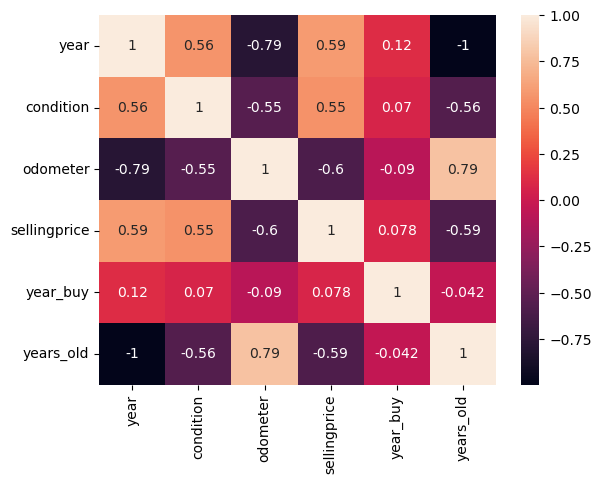

In [38]:
#корреляция Пирсона
sns.heatmap(data_train.corr(), annot = True) #посмотрим корреляции Пирсона
plt.show()

## Выводы по предобработке

Признаки обработаны, пропуски обработаны, данные проверены.

Сильно коррелирующие признаки: год выпуска, пробег и состояние. Они могут быть разные для разных машин, поэтому мультколлинеарности не должно быть. Но year и  years_old вдвоем явно создадут мультколлинеарность, необходимо удалить year

## Обработка для моделей МО

In [39]:
#выделим вин
vin = data_test['vin']

#удалим вин, чтобы не мешал моделям
data_train.drop(columns=['vin'], axis= 1 , inplace= True )
data_test.drop(columns=['vin'], axis= 1 , inplace= True )



#удалим saledate
data_train.drop(columns=['saledate'], axis= 1 , inplace= True )
data_test.drop(columns=['saledate'], axis= 1 , inplace= True )


#удалим year, чтобы исключить мультколлинеарность
data_train.drop(columns=['year'], axis= 1 , inplace= True )
data_test.drop(columns=['year'], axis= 1 , inplace= True )



In [40]:
#разделим на целевой признак 
features = data_train.drop(['sellingprice'],axis=1)
target = data_train['sellingprice'] #целевой признак

features_test = data_test.copy()

In [41]:
#посмотрим явные дубликаты
features.duplicated().sum()

0

In [42]:
#удалим явные дубликаты
features = features.drop_duplicates()
target = target[target.index.isin(features.index)]

### Ordinal Encoding порядковое кодирование 

In [43]:

#закодируем
features_ordinal = features.copy()
features_ordinal_test = features_test.copy()
features_categirical = [ 'make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

encoder = OrdinalEncoder()
encoder.fit(features_ordinal[features_categirical])

features_ordinal[features_categirical] = encoder.transform(features_ordinal[features_categirical] )
features_ordinal_test[features_categirical] = encoder.transform(features_ordinal_test[features_categirical] )





## Построение моделей

### Дерево решений

In [44]:
%%time 
warnings.filterwarnings("ignore") 

model =  tree.DecisionTreeRegressor()

params = {#'splitter': ['best', 'random'],
          #'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
          'max_depth': range (1,50, 5),
          'random_state': [12345]} 

grid_1 = GridSearchCV(model, params, scoring='neg_mean_absolute_percentage_error', cv=5)
grid_1.fit(features_ordinal, target)

print(grid_1.best_params_)
print(grid_1.best_score_)

{'max_depth': 21, 'random_state': 12345}
-0.2355841347330209
Wall time: 1min 59s


### CatBoostRegressor

In [45]:
%%time 
warnings.filterwarnings("ignore") 

model =  CatBoostRegressor()

params = {'iterations': [1000],
          'depth': range (1,50, 5),
          'random_state': [12345]} 

grid_2 = GridSearchCV(model,params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1,  cv=5)
grid_2.fit(features_ordinal, target)

print(grid_2.best_params_)
print(grid_2.best_score_)

Learning rate set to 0.107119
0:	learn: 8944.9228677	total: 1.27s	remaining: 21m 13s
1:	learn: 8299.3623463	total: 2.37s	remaining: 19m 40s
2:	learn: 7720.0866639	total: 3.47s	remaining: 19m 13s
3:	learn: 7252.4788066	total: 4.53s	remaining: 18m 48s
4:	learn: 6813.0054225	total: 5.6s	remaining: 18m 33s
5:	learn: 6455.3465574	total: 6.67s	remaining: 18m 25s
6:	learn: 6108.3734503	total: 7.78s	remaining: 18m 23s
7:	learn: 5805.5782210	total: 8.92s	remaining: 18m 26s
8:	learn: 5537.4641287	total: 10.1s	remaining: 18m 31s
9:	learn: 5312.3557394	total: 11.1s	remaining: 18m 23s
10:	learn: 5114.4278159	total: 12.2s	remaining: 18m 20s
11:	learn: 4901.3755868	total: 13.4s	remaining: 18m 26s
12:	learn: 4741.8522950	total: 14.7s	remaining: 18m 36s
13:	learn: 4608.9530796	total: 15.9s	remaining: 18m 37s
14:	learn: 4483.3939104	total: 16.9s	remaining: 18m 32s
15:	learn: 4373.4901466	total: 18s	remaining: 18m 27s
16:	learn: 4262.1711041	total: 19.1s	remaining: 18m 23s
17:	learn: 4164.1657915	total: 

### LightGBM

In [51]:
%%time 
warnings.filterwarnings("ignore") 

model = LGBMRegressor()

params = {'n_estimators': range (80, 201, 20), 
          'max_depth': range (10, 51, 5),
          'random_state': [42]} 

grid_3 = GridSearchCV(model,params, scoring='neg_mean_absolute_percentage_error',n_jobs=-1,  cv=5)
grid_3.fit(features_ordinal, target)

print(grid_3.best_params_)
print(grid_3.best_score_)

{'max_depth': 15, 'n_estimators': 200, 'random_state': 42}
-0.24906685713205734
Wall time: 9min 31s


### Случайный лес

## Тестирование лучшей модели

In [46]:
%%time 
# Предскажем результаты на тестовой выборке
predictions_test = grid_2.best_estimator_.predict(features_ordinal_test) #features_test

Wall time: 1.14 s


In [47]:
#в порядке возрастания выведем влияние признаков на выбранную модель в процeнтах:
importances = grid_2.best_estimator_.feature_importances_
f_importances = pd.Series(importances, index=features_ordinal.columns).sort_values(ascending=False) #features_test
print(f_importances)

make            22.221959
body            20.678255
model           18.051185
trim            12.736251
years_old       10.488524
odometer         7.868920
condition        3.503792
seller           1.479229
state            0.921678
interior         0.906007
color            0.703454
year_buy         0.359446
transmission     0.081299
dtype: float64


In [48]:
# Создадим датафрейм sample_submission, состоящий из двух столбцов - vin и предсказанные значения цены:
sample_submission = pd.DataFrame({'vin': vin,
                                  'sellingprice': predictions_test})

In [54]:
#это необходимо, поскольку тестовая выборка на платформе изменялась
sample_submission = sample_submission.query('vin != "4s2cm58v9s4375559" & vin != "1ftne2ew6eda13643"')


In [55]:
# Сохраним полученный датафрейм, как 'sample_submission.csv':
sample_submission.to_csv(r'sample_submission.csv', index= False )

После загрузки данных на платформу Kaggle(https://www.kaggle.com/competitions/used-cars-price-prediction-yap17/leaderboard?tab=public) были получены следующие значения метрики МАРЕ: 

Private Score: 15.78268 

Public Score: 15.59415 

Данные результаты были получены после завершения основного времени соревнования, но этот результат  занимал бы 3 место в Private Score и 4 место в Public Score

## Выводы

Данная работа по прогнозированию стоимости автомобилей была реализована в рамках соревнования на платформе kaggle. 

Сырые данные были представлены в виде тренировочного и тестового датасетов. Данные содержали различные признаки характерные для автомобилей. Данные были обработаны: проверены пропуски, выбросы и аномалии, заполнены недостающие значения, добавлены новые столбцы, удалены дубликаты. Также был применен метод определеия некоторых значений с помощью пакета vin, который по идентификационному номеру определяет марку, модель автомобиля. 

Также при подготовке к построению моделей данные были закодированы способом Ordinal Encoding, удалены лишние столбцы, был выбран целевой признак. 

На этапе построения моделей были проверены различные модели, среди которых были деревянные модели и два варианта градиентного бустинга. Наилучшие показатели на кросс-валидации были у  **CatBoostRegressor** со следующими параметрами: 

'depth': 16, 

'iterations': 1000, 

'random_state': 12345}


Хоть модель и показала наибольшее время обучения, было принято решение использовать именно эту модель, поскольку она дает наилучшее значение метрики МАРЕ:


Метрика МАРЕ: 0.1832829214212325


Wall time: 2h 53min 12s

**При тестировании этой модели были получены следующие показатели:**

Private Score: 15.78268

Public Score: 15.59415

Данные результаты были получены после завершения основного времени соревнования, но этот результат занимал бы 3 место в Private Score и 4 место в Public Score


Также был проведен анализ **влияния признаков на модель** и выявлено, что наибольшее влияние на модель оказывают следующие признаки: 

make            22%

body            21%

model           18%

trim            13%

years_old       10%

odometer         8%

condition        4%

seller           1,5%

Остальные признаки почти не влияют на модель(процент влияния меньше процента)
(state, interior, color, year_buy, transmission)




### Возможные улучшения проекта:

1) В данном проекте есть возможность поработать с предобработкой данных в категориальных признаках, где много категорий. Вероятно, не все лексичекие или технические ошибки были удалены в столбцах model или make.

2) Также не все варианты кодирования(или отсутсвия кодирования) данных были опробованы. Стоит попробовать и другие, также как и методы стандартизации и нормировки числовых признаков.

3) Необходимо рассмотреть больше вариантов применения различных моделей машинного обучения, не ограничиваться бустингом, а также рассмотреть больше параметров для уже полученных моделей.
